# ML Quest #1: Demand Forecasting
https://www.patreon.com/ZazenCodes

## Part 3: Forecast

## Sections
1. Load Model and Generate Forecasts
2. Merge Forecast with Past Data
3. Visualize Forecast
4. Upload Predictions to Postgres
5. Dashboard Playground

## Setup

Refer to the Part 1 notebook for setup instructions.

## 1. Load Model and Generate Predictions

In [1]:
from pickle import load
from pathlib import Path

def load_model(model_name, artifact_path="../artifacts"):
    with open(Path(artifact_path) / f"{model_name}.pkl", "rb") as f:
        model = load(f)
    return model
        

model = load_model("boosted_tree")

In [2]:
model

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=10,
                          subsample=0.8)

In [3]:
import pandas as pd

In [5]:
!ls ../data

final_week_processed.csv   meal_demand_historical.csv
full_clean.csv             train_processed.csv


In [18]:
!ls ../artifacts

boosted_tree.pkl               boosted_tree_stack_week_6.pkl
boosted_tree_stack_week_1.pkl  boosted_tree_stack_week_7.pkl
boosted_tree_stack_week_10.pkl boosted_tree_stack_week_8.pkl
boosted_tree_stack_week_11.pkl boosted_tree_stack_week_9.pkl
boosted_tree_stack_week_12.pkl city_name_encoder.pkl
boosted_tree_stack_week_2.pkl  meal_info_encoder.pkl
boosted_tree_stack_week_3.pkl  meal_name_encoder.pkl
boosted_tree_stack_week_4.pkl  price_scaler_encoder.pkl
boosted_tree_stack_week_5.pkl


In [7]:
# Predict next week demand based on final week of data (processed)

df_final_week = pd.read_csv("../data/final_week_processed.csv")

In [12]:
df_final_week

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,price_diff,month_num,quarter_num,year_num,num_orders_last_year,num_orders_last_week,num_orders_rolling_4_weeks,num_orders_rolling_16_weeks,num_orders_last_year_rolling_4_weeks,num_orders_last_year_rolling_16_weeks
0,145,0,0,121,2.0,0,0,0,1,0,...,0.000000,10,4,3,176.0,162.0,533.75,663.1875,81.00,121.5625
1,145,0,0,54,2.0,1,0,0,0,0,...,-0.006224,10,4,3,258.0,190.0,536.75,664.0625,71.00,118.1875
2,145,0,0,135,2.0,1,0,0,0,0,...,0.012447,10,4,3,175.0,122.0,536.50,665.0000,78.25,72.1875
3,145,0,0,15,2.0,0,0,0,1,0,...,0.000000,10,4,3,26.0,27.0,526.50,616.1250,442.75,909.3750
4,145,0,0,96,2.0,0,0,1,0,0,...,0.000000,10,4,3,26.0,81.0,510.00,586.6875,64.75,88.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,145,0,0,68,4.5,1,0,0,0,0,...,0.000000,10,4,3,27.0,123.0,2149.75,2177.6250,11.00,32.6875
3180,145,0,0,42,4.5,0,1,0,0,0,...,0.000000,10,4,3,28.0,13.0,2281.75,2165.0625,269.50,390.6875
3181,145,0,0,501,4.5,1,0,0,0,0,...,0.518996,10,4,3,94.0,770.0,2262.00,2151.6875,0.00,0.0000
3182,145,0,0,729,4.5,0,1,0,0,0,...,0.434664,10,4,3,243.0,811.0,2116.25,2126.2500,0.00,0.0000


In [13]:
"next_week_num_orders" in df_final_week.columns

False

In [14]:
df_final_week[df_final_week.isnull().any(axis=1)]

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,price_diff,month_num,quarter_num,year_num,num_orders_last_year,num_orders_last_week,num_orders_rolling_4_weeks,num_orders_rolling_16_weeks,num_orders_last_year_rolling_4_weeks,num_orders_last_year_rolling_16_weeks


In [16]:
from tqdm import tqdm

In [19]:
def predict_demand(df_week_x, future_weeks=12):
    y_preds = []
    city_ids = df_week_x.city_id.values
    meal_ids = df_week_x.meal_id.values
    assert "next_week_num_orders" not in df_week_x.columns
    assert "target_num_orders" not in df_week_x.columns
    X_pred = df_week_x
    initial_week_number = int(df_week_x.week_number.max())
    for future_week_offset in tqdm(list(range(1, future_weeks+1))):
        pred_week_num = initial_week_number + future_week_offset
        print(f"Predicting for week {pred_week_num}")
        model = load_model(f"boosted_tree_stack_week_{future_week_offset}")
        y_pred = model.predict(X_pred)
        y_preds.extend([{
            "period": "Future",
            "week_number": pred_week_num,
            "num_orders": y,
            "city_id": city_id,
            "meal_id": meal_id,
        } for y, city_id, meal_id in zip(y_pred, city_ids, meal_ids)])
    
    df_preds = pd.DataFrame(y_preds)
    return df_preds


df_future = predict_demand(df_final_week)
df_future

100%|██████████| 12/12 [00:00<00:00, 73.43it/s]


Predicting for week 146
Predicting for week 147
Predicting for week 148
Predicting for week 149
Predicting for week 150
Predicting for week 151
Predicting for week 152
Predicting for week 153
Predicting for week 154
Predicting for week 155
Predicting for week 156
Predicting for week 157


,period,week_number,num_orders,city_id,meal_id
0,Future,146,145.827863,9,50
1,Future,146,143.757585,9,48
2,Future,146,142.096821,9,37
3,Future,146,26.701091,9,8
4,Future,146,70.707177,9,23
...,...,...,...,...,...
38203,Future,157,81.525376,33,17
38204,Future,157,45.470396,33,15
38205,Future,157,347.083510,33,41
38206,Future,157,396.560316,33,39


## 2. Merge Forecast with Past Data

In [20]:
import numpy as np

In [21]:
class OrderedCategoryEncoder:
    def __init__(self):
        self.categories_: list[str] = None
        self.category_map: dict[str: int] = None
        self.inverse_category_map: dict[int: str] = None

    def fit(self, ordered_categories: list[str]):
        self.categories_ = ordered_categories
        self.category_map = {category: i+1 for i, category in enumerate(ordered_categories)}
        self.inverse_category_map = {i+1: category for i, category in enumerate(ordered_categories)}

    def transform(self, values: list[str]) -> np.array:
        if set(values) - set(self.category_map):
            for value in values:
                if value not in self.category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.category_map[value] for value in values])
    
    def inverse_transform(self, values: list[int]) -> np.array:
        if set(values) - set(self.inverse_category_map):
            for value in values:
                if value not in self.inverse_category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.inverse_category_map[value] for value in values])


In [23]:
import re

def load_encoders(artifact_path="../artifacts"):
    encoders = {}
    for file_path in Path(artifact_path).glob("*encoder.pkl"):
        print(file_path)
        with open(file_path, "rb") as f:
            print(file_path.name)
            encoders[re.findall(r"(.*)_encoder", file_path.name)[0]] = load(f)
    return encoders

encoders = load_encoders()
encoders.keys()

../artifacts/meal_name_encoder.pkl
meal_name_encoder.pkl
../artifacts/city_name_encoder.pkl
city_name_encoder.pkl
../artifacts/price_scaler_encoder.pkl
price_scaler_encoder.pkl
../artifacts/meal_info_encoder.pkl
meal_info_encoder.pkl


dict_keys(['meal_name', 'city_name', 'price_scaler', 'meal_info'])

In [24]:
df_past = pd.read_csv(f"../data/full_clean.csv")

In [25]:
df_past["period"] = "Past"

In [26]:
df_past.columns

Index(['week_number', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'num_orders', 'op_area', 'Meat', 'Other',
       'Seafood', 'Vegetarian', 'beverage', 'dessert', 'main', 'side',
       'starter', 'city_id', 'meal_id', 'period'],
      dtype='object')

In [27]:
columns = ["week_number", "num_orders", "city_id", "meal_id", "period"]
df = pd.concat((df_past[columns], df_future[columns]), axis=0, ignore_index=True)

In [28]:
df.dtypes

week_number      int64
num_orders     float64
city_id          int64
meal_id          int64
period          object
dtype: object

In [29]:
df["current_week"] = 146

In [30]:
df["city_name"] = encoders["city_name"].inverse_transform(df.city_id)

In [32]:
df["meal_name"] = encoders["meal_name"].inverse_transform(df.meal_id)

In [33]:
df = df.drop(columns=["city_id", "meal_id"])

In [34]:
df[df.period == "Past"].week_number.max()

np.int64(145)

In [35]:
df[df.period == "Future"].week_number.min()

np.int64(146)

In [36]:
df

,week_number,num_orders,period,current_week,city_name,meal_name
0,1,177.000000,Past,146,Brackenbury,Mushroom Stew
1,1,270.000000,Past,146,Brackenbury,Dwarven Meat Pie
2,1,189.000000,Past,146,Brackenbury,Dragonfire Chili
3,1,54.000000,Past,146,Brackenbury,Stuffed Mushrooms
4,1,40.000000,Past,146,Brackenbury,Grilled Trout with Lemon
...,...,...,...,...,...,...
484935,157,81.525376,Future,146,Meadowbrook,Fire-Grilled Venison
484936,157,45.470396,Future,146,Meadowbrook,Forest Berry Pie
484937,157,347.083510,Future,146,Meadowbrook,Savory Meat Pies
484938,157,396.560316,Future,146,Meadowbrook,Apple and Raisin Bread


## 3. Visualize Forecast

<Axes: xlabel='week_number'>

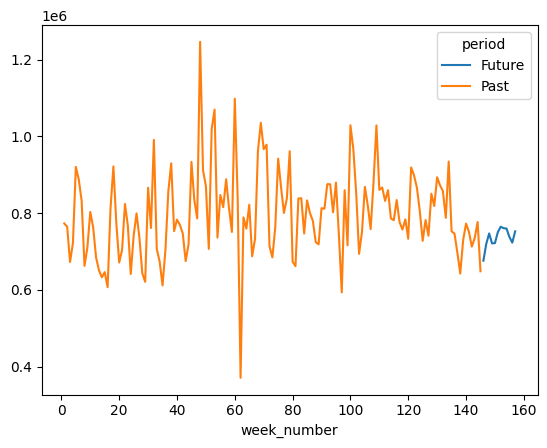

In [37]:
df.groupby(["week_number", "period"]).num_orders.sum().unstack().plot()

In [38]:
import matplotlib.pyplot as plt

In [39]:
def plot_demand_for_meal(meal_name):
    df[df.meal_name == meal_name].groupby(["week_number", "period"]).num_orders.sum().unstack().plot(title=meal_name)
    plt.show()

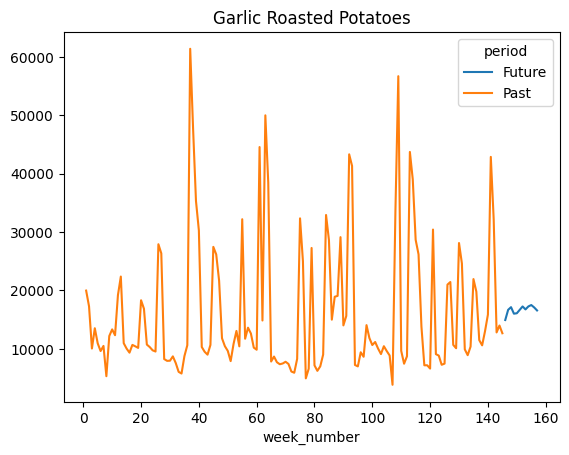

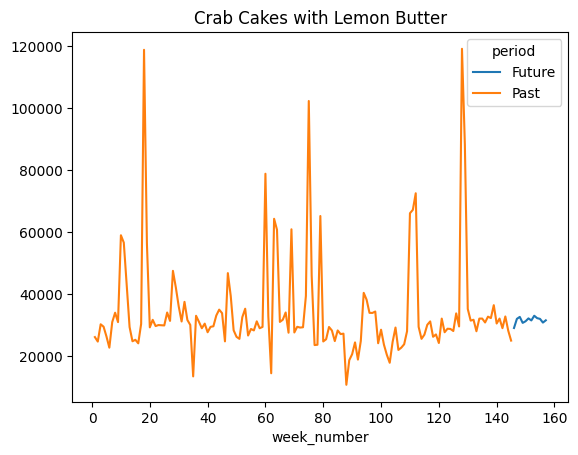

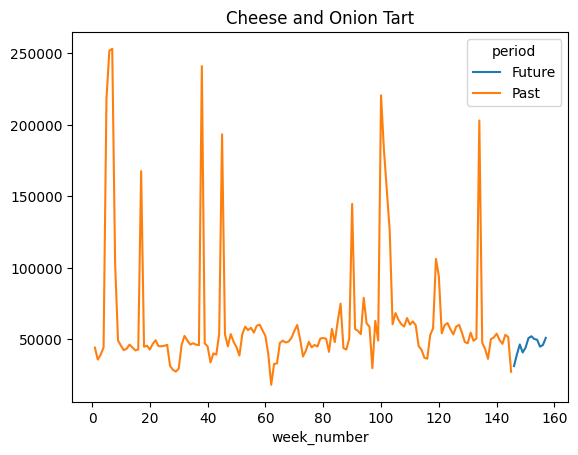

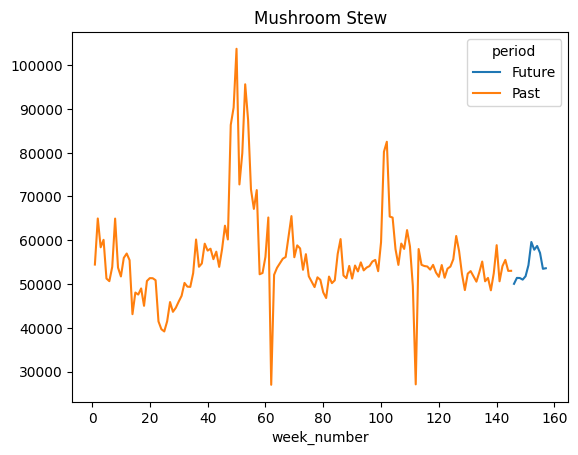

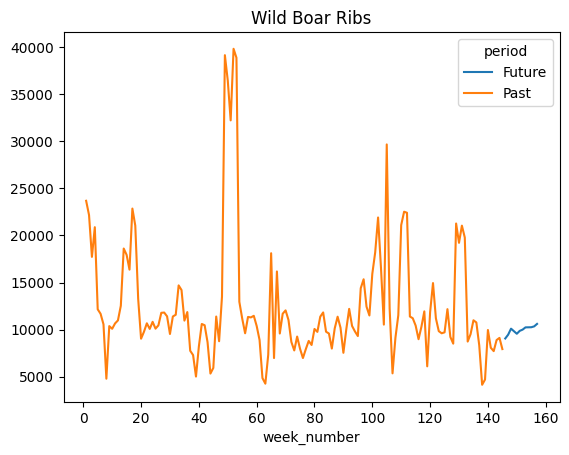

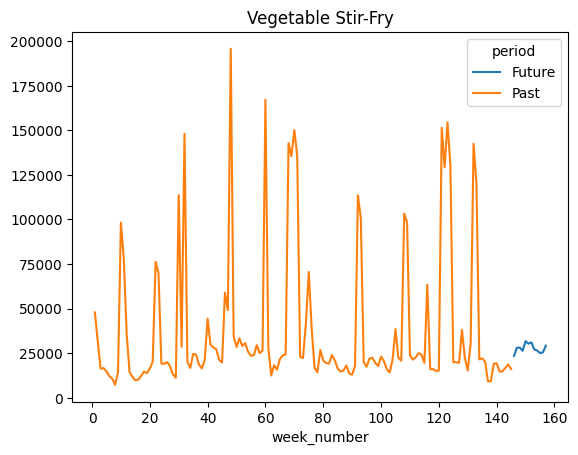

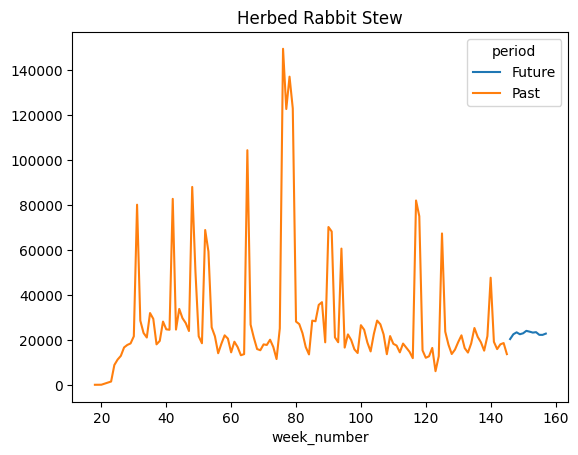

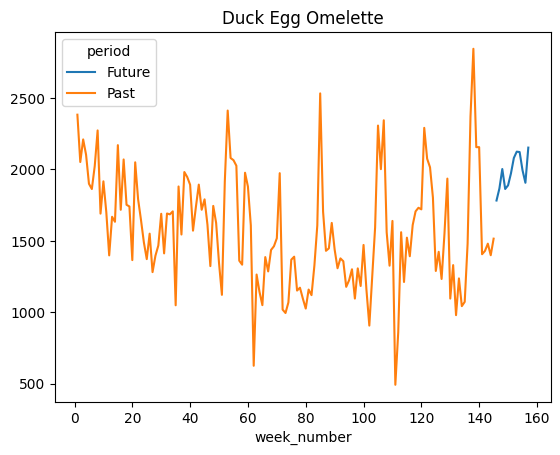

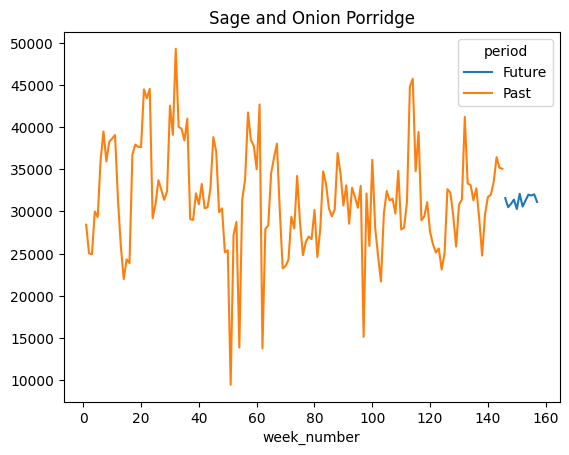

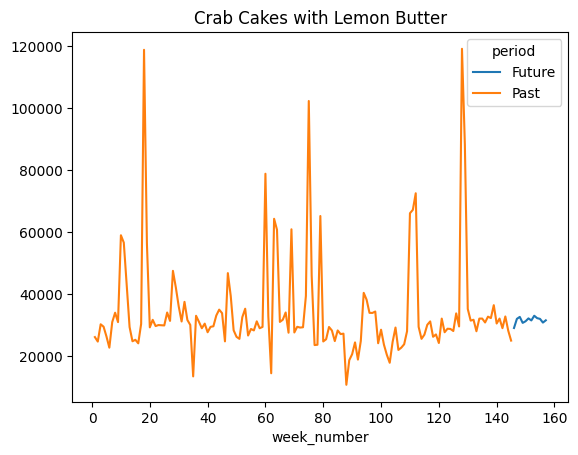

In [40]:
for meal_name in df.meal_name.sample(10):
    plot_demand_for_meal(meal_name)

## 4. Upload to Postgres

In [44]:
!rm -r ../postgres_data

In [45]:
!mkdir -p ../postgres_data

In [46]:
!docker run --name ml-quest-postgres \
    --rm -d \
    -e POSTGRES_HOST_AUTH_METHOD=trust \
    -p 5432:5432 \
    -v ./../postgres_data:/var/lib/postgresql/data \
    postgres:13

0e5b72f2e251d6361d92c8a8d420b00e9cc3c115362daf6c963d4ae0d0a876ab


In [47]:
!docker ps | grep postgres

0e5b72f2e251   postgres:13   "docker-entrypoint.s…"   8 seconds ago   Up 7 seconds   0.0.0.0:5432->5432/tcp   ml-quest-postgres


In [48]:
import pandas as pd
import psycopg2
from psycopg2 import sql

def upload_to_postgres(df, table_name, dbname="postgres", user="postgres", host='localhost', port=5432):
    # Connect to PostgreSQL
    conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port)
    cur = conn.cursor()
    
    # Create table if it doesn't exist
    create_table_query = sql.SQL("""
        CREATE TABLE IF NOT EXISTS {table} (
            {fields}
        )
    """).format(
        table=sql.Identifier(table_name),
        fields=sql.SQL(', ').join(
            sql.SQL("{} {}").format(sql.Identifier(col), sql.SQL(pandas_to_postgres_type(str(df[col].dtype)))) for col in df.columns
        )
    )
    cur.execute(create_table_query)
    conn.commit()

    # Insert data into table
    for index, row in df.iterrows():
        insert_query = sql.SQL("""
            INSERT INTO {table} ({fields}) VALUES ({values})
        """).format(
            table=sql.Identifier(table_name),
            fields=sql.SQL(', ').join(map(sql.Identifier, df.columns)),
            values=sql.SQL(', ').join(sql.Placeholder() * len(df.columns))
        )
        cur.execute(insert_query, tuple(row))
    
    conn.commit()
    cur.close()
    conn.close()

def pandas_to_postgres_type(dtype):
    if dtype == 'int64':
        return 'INTEGER'
    elif dtype == 'float64':
        return 'FLOAT'
    elif dtype == 'bool':
        return 'BOOLEAN'
    else:
        return 'TEXT'



In [49]:
upload_to_postgres(df, "current_meal_demand")

In [50]:
def run_query(query, fetch=True, dbname="postgres", user="postgres", host='localhost', port=5432):
    # Connect to PostgreSQL
    conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port)
    cur = conn.cursor()

    # Execute the SELECT query
    cur.execute(query)
    
    if fetch:
        # Fetch the results
        rows = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]

        # Close the cursor and connection
        cur.close()
        conn.close()

        # Convert to DataFrame
        df = pd.DataFrame(rows, columns=colnames)
        
        return df


In [51]:
run_query("select * from current_meal_demand limit 10")

,week_number,num_orders,period,current_week,city_name,meal_name
0,1,177.0,Past,146,Brackenbury,Mushroom Stew
1,1,270.0,Past,146,Brackenbury,Dwarven Meat Pie
2,1,189.0,Past,146,Brackenbury,Dragonfire Chili
3,1,54.0,Past,146,Brackenbury,Stuffed Mushrooms
4,1,40.0,Past,146,Brackenbury,Grilled Trout with Lemon
5,1,28.0,Past,146,Brackenbury,Venison Jerky
6,1,190.0,Past,146,Brackenbury,Beef and Ale Stew
7,1,391.0,Past,146,Brackenbury,Sage and Onion Porridge
8,1,472.0,Past,146,Brackenbury,Pumpkin Soup
9,1,676.0,Past,146,Brackenbury,Basil and Tomato Soup


In [52]:
run_query("""
    select
        t.*,
        rank() over (order by t.total_forecasted_orders)
    from (
        select city_name, meal_name, sum(num_orders) as total_forecasted_orders
        from current_meal_demand
        where period = 'Future'
        group by city_name, meal_name
        order by total_forecasted_orders desc
        limit 10
    ) t
""")

,city_name,meal_name,total_forecasted_orders,rank
0,Briarwood,Fish and Chips,22762.386893,1
1,Mirthwood,Mushroom Stew,22890.229581,2
2,Stormwatch,Mushroom Stew,23040.992409,3
3,Invermere,Mushroom Stew,23172.744727,4
4,Tanglewood,Mushroom Stew,23335.379344,5
5,Kingsholm,Mushroom Stew,23928.625566,6
6,Briarwood,Pumpkin Soup,24432.444258,7
7,Kingsholm,Cheese and Onion Tart,24702.714803,8
8,Briarwood,Cheese and Onion Tart,25929.132310,9
9,Briarwood,Mushroom Stew,28255.642543,10


In [53]:
from datetime import datetime

In [54]:
run_query(f"""
CREATE TABLE IF NOT EXISTS current_meal_demand_metadata (
    updated_date date
);
INSERT INTO current_meal_demand_metadata values ('{datetime.now().date().isoformat()}');
COMMIT;
""", fetch=False)

In [55]:
run_query("select * from current_meal_demand_metadata;")

,updated_date
0,2024-08-07


In [56]:
!docker ps | grep postgres

0e5b72f2e251   postgres:13   "docker-entrypoint.s…"   2 minutes ago   Up 2 minutes   0.0.0.0:5432->5432/tcp   ml-quest-postgres


In [57]:
!docker stop ml-quest-postgres

ml-quest-postgres


In [58]:
!docker ps | grep postgres

## 5. Dashboard Playground